# Alaska evaluation

## Define filepaths

In [1]:
root_dir = '../..'
data_dir = 'data'
corpus_dir = 'corpus'
rank_dir = 'terms'

## Load ground truth

In [2]:
import os
import json

In [3]:
gt_filename = 'alaska_camera_gt.json'
gt_filepath = os.path.join(root_dir, data_dir, corpus_dir, gt_filename)

In [4]:
with open(gt_filepath, 'r') as fd:
    gt_dict = json.load(fd)

In [5]:
from pprint import pprint

In [6]:
pprint(gt_dict)

{'ENTITY#101': 'canon eos 5d mark iii',
 'ENTITY#102': 'canon eos 5d mark ii',
 'ENTITY#16': 'nikon d90',
 'ENTITY#18': 'canon eos 60d',
 'ENTITY#19': 'nikon d3300',
 'ENTITY#21': 'nikon d5100',
 'ENTITY#23': 'canon eos 7d',
 'ENTITY#36': 'nikon d3100',
 'ENTITY#37': 'nikon d80',
 'ENTITY#41': 'nikon d5200',
 'ENTITY#44': 'nikon d3200',
 'ENTITY#57': 'nikon d800',
 'ENTITY#58': 'nikon 1 j1',
 'ENTITY#6': 'nikon d5300',
 'ENTITY#7': 'olympus omd em5',
 'ENTITY#75': 'nikon d7000',
 'ENTITY#76': 'nikon d610',
 'ENTITY#8': 'nikon 1 j3',
 'ENTITY#84': 'nikon d300',
 'ENTITY#96': 'canon eos 70d'}


## Load rankings

### LIME on GloVe-based neural network

In [7]:
import pandas as pd

In [8]:
glove_nn_rank_filename = 'ranking_alaska_nn.xlsx'
glove_nn_rank_filepath = os.path.join(root_dir, data_dir, rank_dir, glove_nn_rank_filename)

In [9]:
glove_nn_rank_df = pd.read_excel(glove_nn_rank_filepath, index_col=0)
# Replace '_' character with whitespaces
glove_nn_rank_df['term'] = glove_nn_rank_df['term'].map(lambda x: x.replace('_', ' '))
glove_nn_rank_df['term'] = glove_nn_rank_df['term'].map(lambda x: x.replace('-', ''))
glove_nn_rank_df.head()

,label,term,weight
0,ENTITY#101,5d mark iii,38.210490
1,ENTITY#101,5d mark,10.682544
2,ENTITY#101,canon eos 5d mark iii 22 3 mp full frame,3.825436
3,ENTITY#101,canon eos 5d mark iii body,3.609619
4,ENTITY#101,5d mark iii body,2.965371


In [10]:
glove_nn_rank_df.shape

(2039, 3)

### LIME on DistilBERT

In [11]:
bert_rank_filename = 'ranking_alaska_bert.xlsx'
bert_rank_filepath = os.path.join(root_dir, data_dir, rank_dir, bert_rank_filename)

In [12]:
bert_rank_df = pd.read_excel(bert_rank_filepath, index_col=0)
# Replace '_' character with whitespaces
bert_rank_df['term'] = bert_rank_df['term'].map(lambda x: x.replace('_', ' '))
bert_rank_df['term'] = bert_rank_df['term'].map(lambda x: x.replace('-', ''))
bert_rank_df.head()

,label,term,weight
0,ENTITY#101,5d mark iii,34.716910
1,ENTITY#101,5d mark,7.262597
2,ENTITY#101,canon eos 5d mark iii 22 3 mp full frame,3.797256
3,ENTITY#101,canon eos 5d mark iii body,3.530062
4,ENTITY#101,canon eos,2.991098


In [13]:
bert_rank_df.shape

(869, 3)

### TF-IDF baseline

In [14]:
tfidf_rank_filename = 'ranking_alaska_baseline.xlsx'
tfidf_rank_filepath = os.path.join(root_dir, data_dir, rank_dir, tfidf_rank_filename)

In [15]:
tfidf_rank_df = pd.read_excel(tfidf_rank_filepath, index_col=0)
tfidf_rank_df['term'] = tfidf_rank_df['term'].map(lambda x: x.replace('_', ' '))
tfidf_rank_df['term'] = tfidf_rank_df['term'].map(lambda x: x.replace('-', ''))
tfidf_rank_df.head()

,label,term
0,ENTITY#44,d3200
1,ENTITY#44,nikon d3200
2,ENTITY#44,18
3,ENTITY#44,nikon
4,ENTITY#44,24 2 mp digital slr camera black kit


In [16]:
tfidf_rank_df.shape

(55360, 2)

### BART baseline

Load summaries

In [17]:
summaries_filename = 'chunk_summary_alaska.xlsx'
summaries_filepath = os.path.join(root_dir, data_dir, rank_dir, summaries_filename)

In [18]:
summaries_df = pd.read_excel(summaries_filepath, index_col=0)
summaries_df.head()

,summary
entity,
ENTITY#44,nikon_d3200_digital_slr_camera 24_2_megapixels...
ENTITY#23,ebay_canon_eos_7d sale 734 39. camera 28_135mm...
ENTITY#18,camerafarm_australia canon eos 60d 18 1x optic...
ENTITY#36,ebay_nikon_d3100 18-55/3_5-5_6_vr 55-300/4 5 5...
ENTITY#41,ebay buy nikon_d5200_digital_slr_camera black ...


Rank terms based on their position

In [19]:
summary_rank_list = []

In [20]:
for idx, row in summaries_df.iterrows():
    summary = row['summary']
    for term in summary.split():
        entry = (idx, term)
        summary_rank_list.append(entry)

In [21]:
summary_rank_df = pd.DataFrame(summary_rank_list, columns=['label', 'term'])
summary_rank_df['term'] = summary_rank_df['term'].map(lambda x: x.replace('_', ' '))
summary_rank_df['term'] = summary_rank_df['term'].map(lambda x: x.replace('-', ''))
summary_rank_df.head()

,label,term
0,ENTITY#44,nikon d3200 digital slr camera
1,ENTITY#44,24 2 megapixels
2,ENTITY#44,less
3,ENTITY#44,walmart
4,ENTITY#44,com


In [22]:
summary_rank_df.shape

(298, 2)

## Compute metrics

In [23]:
src_dir = 'src'

In [24]:
import sys
sys.path.append(os.path.join(root_dir, src_dir))

In [25]:
tfidf_metrics_list = []
summary_metrics_list = []
glove_metrics_list = []
bert_metrics_list = []

In [26]:
grouped_tfidf_df = tfidf_rank_df.groupby('label')
grouped_summary_df = summary_rank_df.groupby('label')
grouped_glove_df = glove_nn_rank_df.groupby('label')
grouped_bert_df = bert_rank_df.groupby('label')

In [27]:
from metrics import compute_metrics

In [28]:
for group_name, group_data in grouped_tfidf_df:
    # compute metrics for the tf-idf baseline
    tfidf_terms = group_data['term'].values
    tfidf_metrics = compute_metrics(group_name, gt_dict, tfidf_terms)
    tfidf_metrics_list.append(tfidf_metrics)
    
    # compute metrics for the summary-based baseline
    summary_terms = grouped_summary_df.get_group(group_name)['term'].values
    summary_metrics = compute_metrics(group_name, gt_dict, summary_terms)
    summary_metrics_list.append(summary_metrics)
    
    # compute metrics for the glove-based neural network rankings
    glove_terms = grouped_glove_df.get_group(group_name)['term'].values
    glove_metrics = compute_metrics(group_name, gt_dict, glove_terms)
    glove_metrics_list.append(glove_metrics)
    
    # compute metrics for the bert-based neural network rankings
    bert_terms = grouped_bert_df.get_group(group_name)['term'].values
    bert_metrics = compute_metrics(group_name, gt_dict, bert_terms)
    bert_metrics_list.append(bert_metrics)

## Plot metrics

In [29]:
from plot import compare_boxplots, compare_lineplots, show_barplot

In [30]:
use_plotly = False

if not use_plotly:
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'

**Metric #1**: minimum value of `k` s.t `recall[k] > threshold` where `threshold = 0.9`

In [31]:
tfidf_k_recall = [entry['k_recall'] for entry in tfidf_metrics_list if entry['k_recall'] is not None]
summary_k_recall = [entry['k_recall'] for entry in summary_metrics_list if entry['k_recall'] is not None]
glove_k_recall = [entry['k_recall'] for entry in glove_metrics_list if entry['k_recall'] is not None]
bert_k_recall = [entry['k_recall'] for entry in bert_metrics_list if entry['k_recall'] is not None]

In [32]:
print(f'TF-IDF baseline size: {len(tfidf_k_recall)}')
print(f'Summary baseline size: {len(summary_k_recall)}')
print(f'Glove-based network size: {len(glove_k_recall)}')
print(f'BERT-based network size: {len(bert_k_recall)}')

TF-IDF baseline size: 20
Summary baseline size: 20
Glove-based network size: 20
BERT-based network size: 20


In [33]:
plot_labels = ['TF-IDF', 'Summary', 'GloVe', 'BERT']

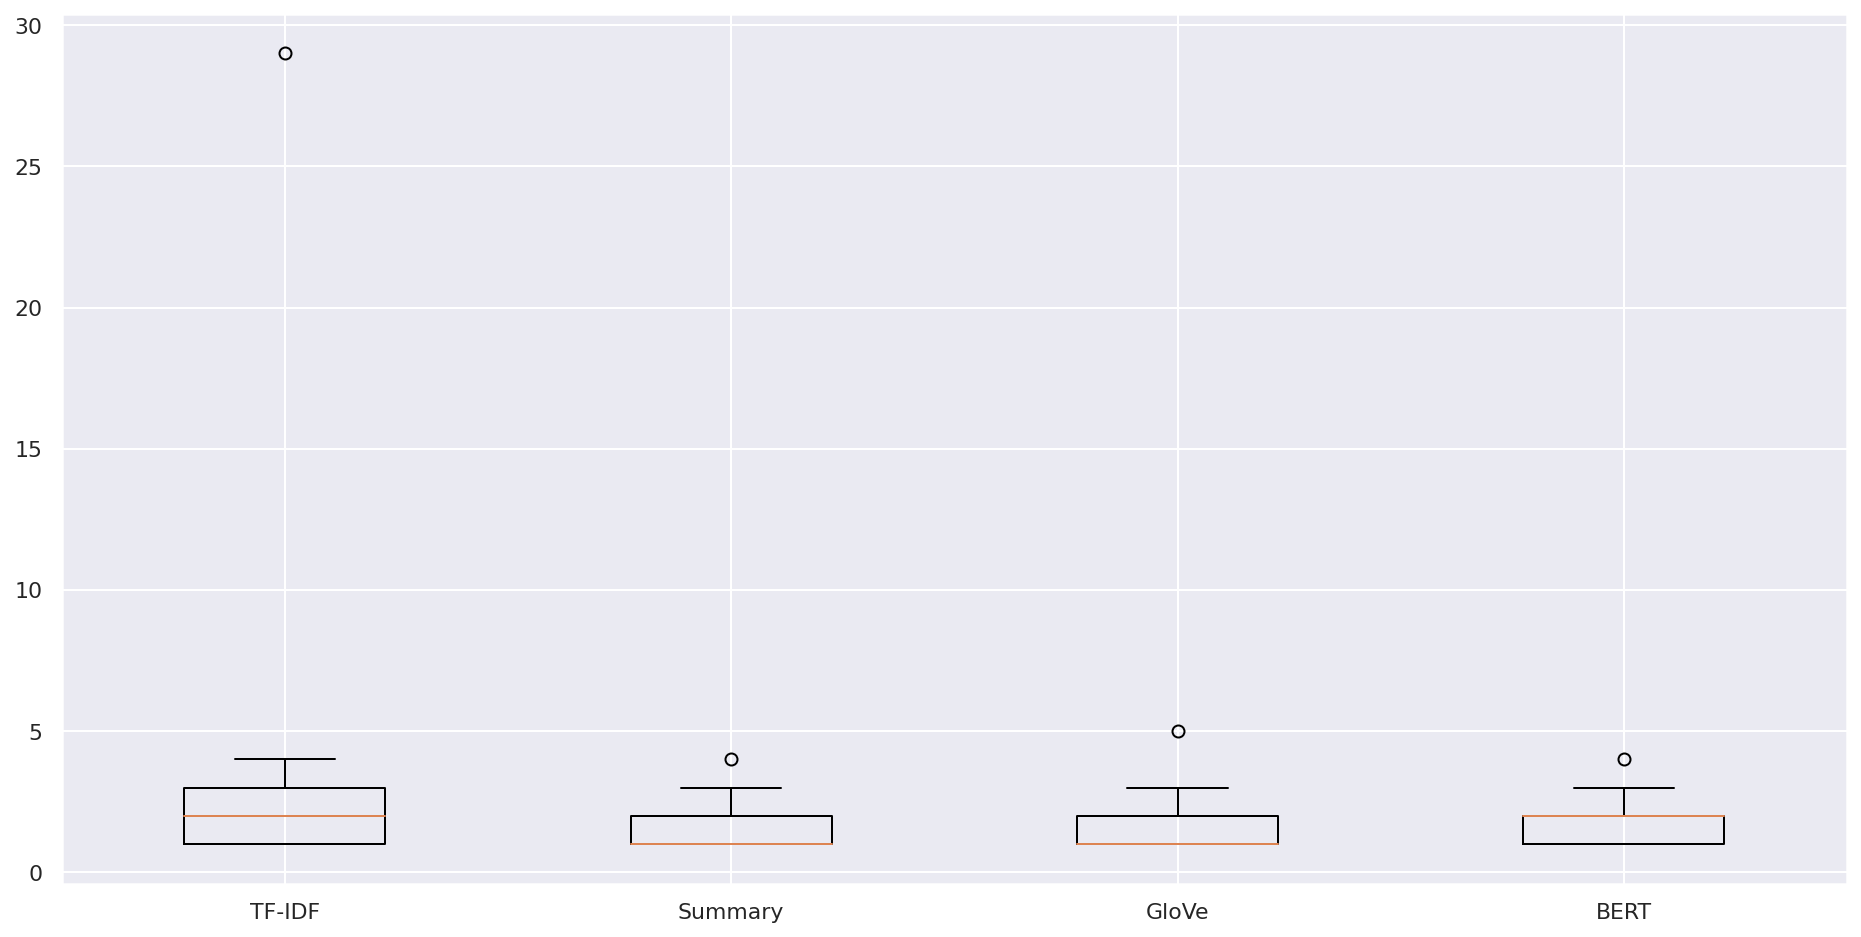

In [34]:
compare_boxplots([tfidf_k_recall, summary_k_recall, glove_k_recall, bert_k_recall], 
                 plot_labels, 
                 use_plotly)

**Metric 2**: maximum F1-score at k

In [35]:
ignore_ids = ['Q1484620', 'Q153721', 'Q383502', 'Q647093', 'Q971268', 'Q1067027', 'Q22713116']

In [36]:
min_k = sys.maxsize
min_name = None
for group_name, group_data in grouped_tfidf_df:
    tmp_min = min(group_data.shape[0], 
                  grouped_summary_df.get_group(group_name).shape[0], 
                  grouped_glove_df.get_group(group_name).shape[0], 
                  grouped_bert_df.get_group(group_name).shape[0])
    if tmp_min < min_k and group_name not in ignore_ids:
        min_name = group_name
        min_k = tmp_min
        
min_k += 1 # starts from zero

In [37]:
print(min_name, min_k, sep=' ')

ENTITY#21 7


In [38]:
tfidf_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_f1score_avg = [sum(col)/len(col) for col in zip(*tfidf_max_f1score)]

summary_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_f1score_avg = [sum(col)/len(col) for col in zip(*summary_max_f1score)]

glove_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_f1score_avg = [sum(col)/len(col) for col in zip(*glove_max_f1score)]

bert_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_f1score_avg = [sum(col)/len(col) for col in zip(*bert_max_f1score)]

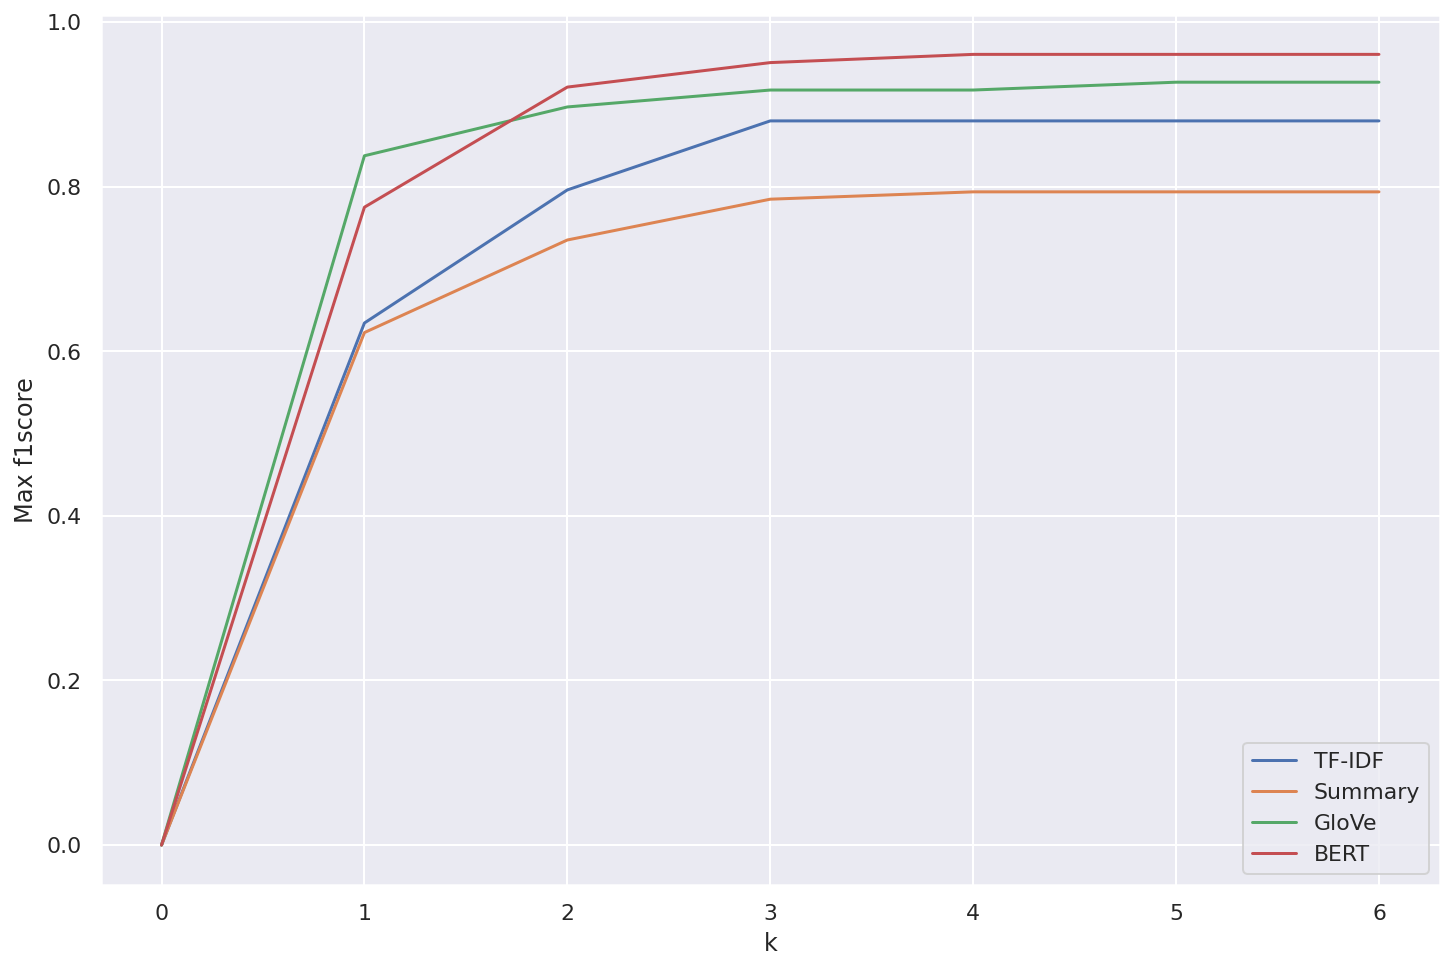

In [39]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_f1score_avg, summary_max_f1score_avg, glove_max_f1score_avg, bert_max_f1score_avg],
                  plot_labels,
                  'k', 
                  'Max f1score', 
                  use_plotly)

**Metric 3**: argmax f1-score

In [40]:
tfidf_argmax_f1score = [entry['argmax_f1score'] for entry in tfidf_metrics_list if entry['argmax_f1score'] is not None]
summary_argmax_f1score = [entry['argmax_f1score'] for entry in summary_metrics_list if entry['argmax_f1score'] is not None]
glove_argmax_f1score = [entry['argmax_f1score'] for entry in glove_metrics_list if entry['argmax_f1score'] is not None]
bert_argmax_f1score = [entry['argmax_f1score'] for entry in bert_metrics_list if entry['argmax_f1score'] is not None]

In [41]:
print(f'tfidf_argmax_f1score size: {len(tfidf_argmax_f1score)}')
print(f'summary_argmax_f1score size: {len(summary_argmax_f1score)}')
print(f'glove_argmax_f1score size: {len(glove_argmax_f1score)}')
print(f'bert_argmax_f1score size: {len(bert_argmax_f1score)}')

tfidf_argmax_f1score size: 20
summary_argmax_f1score size: 20
glove_argmax_f1score size: 20
bert_argmax_f1score size: 20


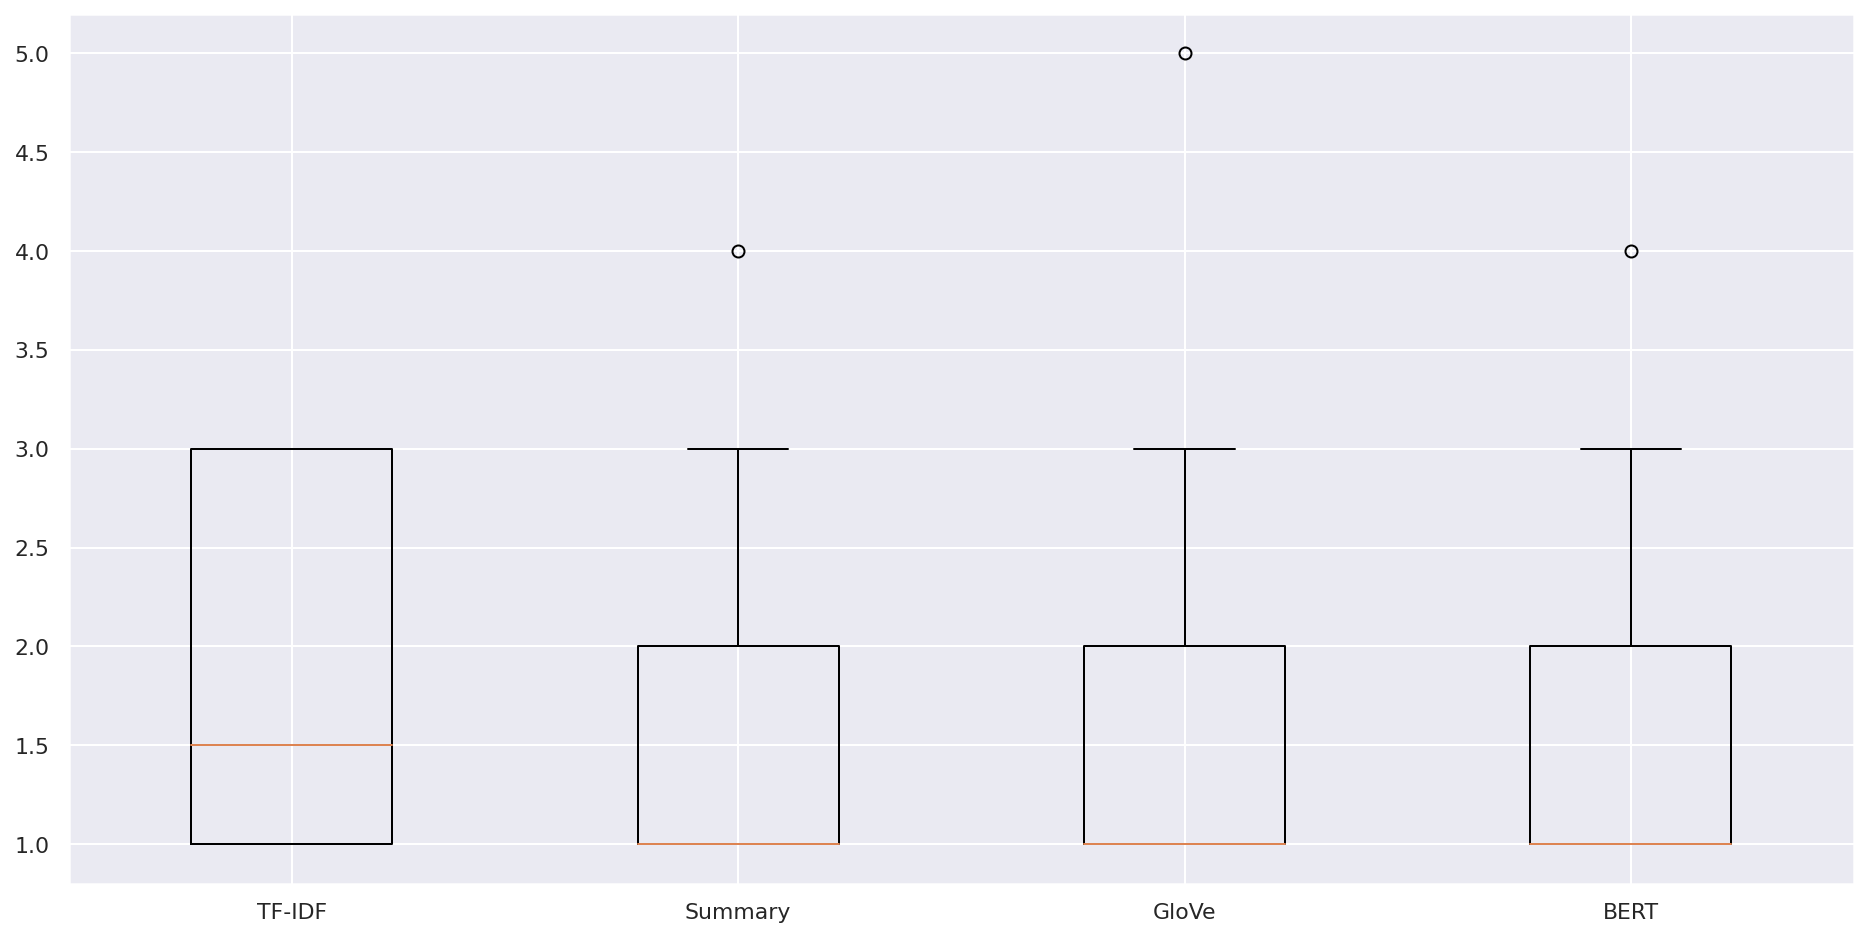

In [42]:
compare_boxplots([tfidf_argmax_f1score, summary_argmax_f1score, glove_argmax_f1score, bert_argmax_f1score],
                 plot_labels, 
                 use_plotly)

**Metric 4**: maximum F2-score at k

In [43]:
tfidf_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_f2score_avg = [sum(col)/len(col) for col in zip(*tfidf_max_f2score)]

summary_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_f2score_avg = [sum(col)/len(col) for col in zip(*summary_max_f2score)]

glove_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_f2score_avg = [sum(col)/len(col) for col in zip(*glove_max_f2score)]

bert_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_f2score_avg = [sum(col)/len(col) for col in zip(*bert_max_f2score)]

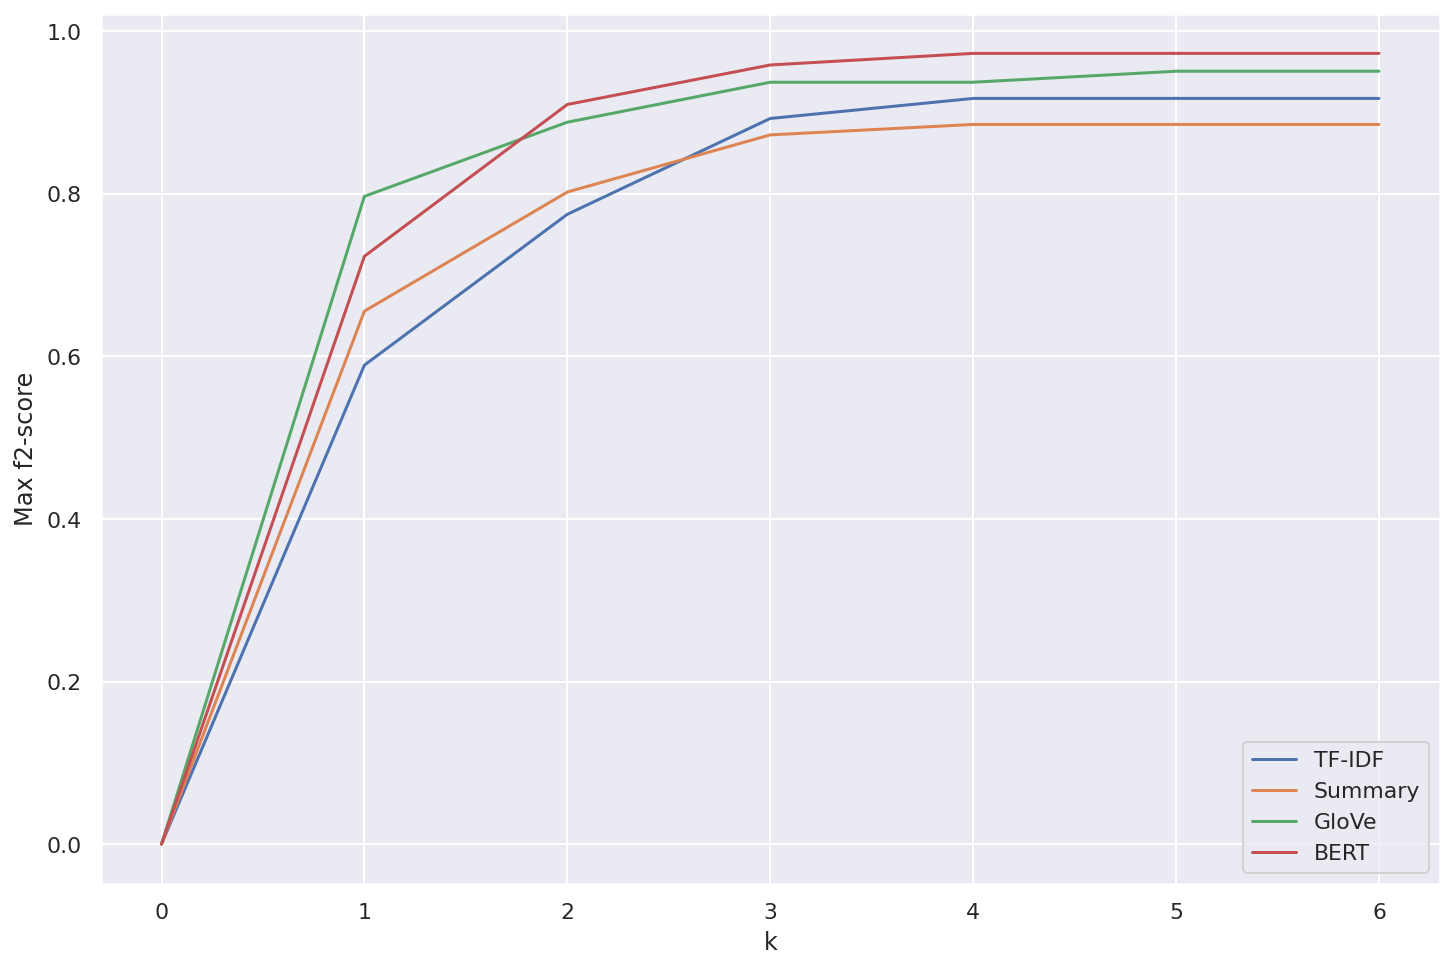

In [44]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_f2score_avg, summary_max_f2score_avg, glove_max_f2score_avg, bert_max_f2score_avg],
                  plot_labels,
                  'k', 
                  'Max f2-score', 
                  use_plotly)

**Metric 5**: maximum F0.5-score at k

In [45]:
tfidf_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_f05score_avg = [sum(col)/len(col) for col in zip(*tfidf_max_f05score)]

summary_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_f05score_avg = [sum(col)/len(col) for col in zip(*summary_max_f05score)]

glove_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_f05score_avg = [sum(col)/len(col) for col in zip(*glove_max_f05score)]

bert_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_f05score_avg = [sum(col)/len(col) for col in zip(*bert_max_f05score)]

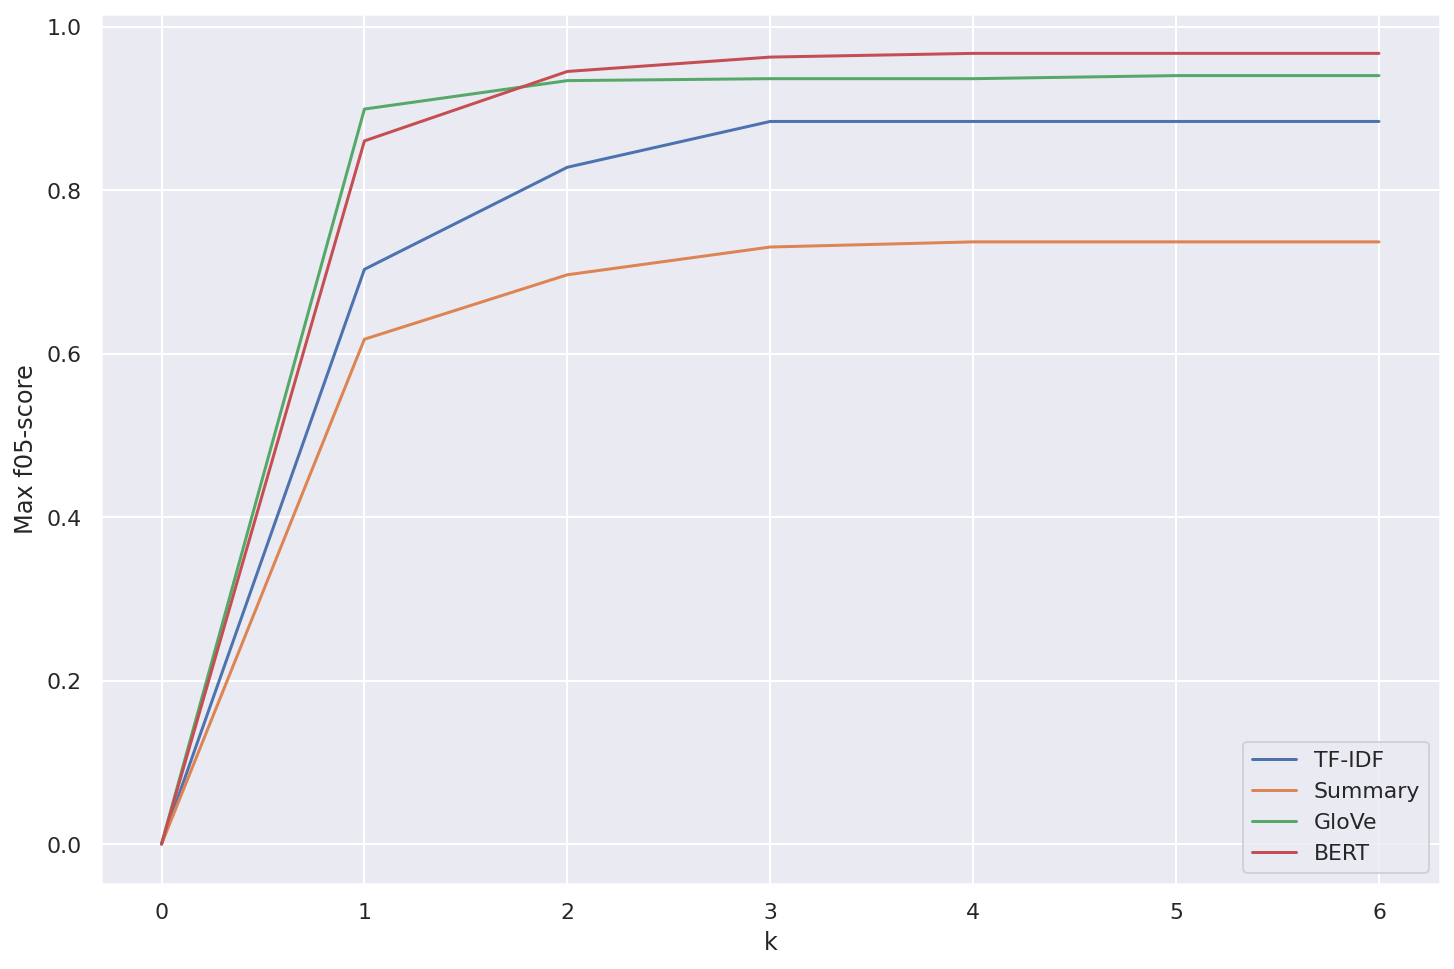

In [46]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_f05score_avg, summary_max_f05score_avg, glove_max_f05score_avg, bert_max_f05score_avg],
                  plot_labels,
                  'k', 
                  'Max f05-score', 
                  use_plotly)

**Metric 6**: `max(recall[i])` s.t `precision[i] > threshold` where `threshold = 0.9`

In [47]:
tfidf_max_recall = [entry['max_recall'] for entry in tfidf_metrics_list if entry['max_recall'] is not None]
summary_max_recall = [entry['max_recall'] for entry in summary_metrics_list if entry['max_recall'] is not None]
glove_max_recall = [entry['max_recall'] for entry in glove_metrics_list if entry['max_recall'] is not None]
bert_max_recall = [entry['max_recall'] for entry in bert_metrics_list if entry['max_recall'] is not None]

In [48]:
print(f'tfidf_max_recall size: {len(tfidf_max_recall)}')
print(f'summary_max_recall size: {len(summary_max_recall)}')
print(f'glove_max_recall size: {len(glove_max_recall)}')
print(f'bert_max_recall size: {len(bert_max_recall)}')

tfidf_max_recall size: 15
summary_max_recall size: 7
glove_max_recall size: 19
bert_max_recall size: 19


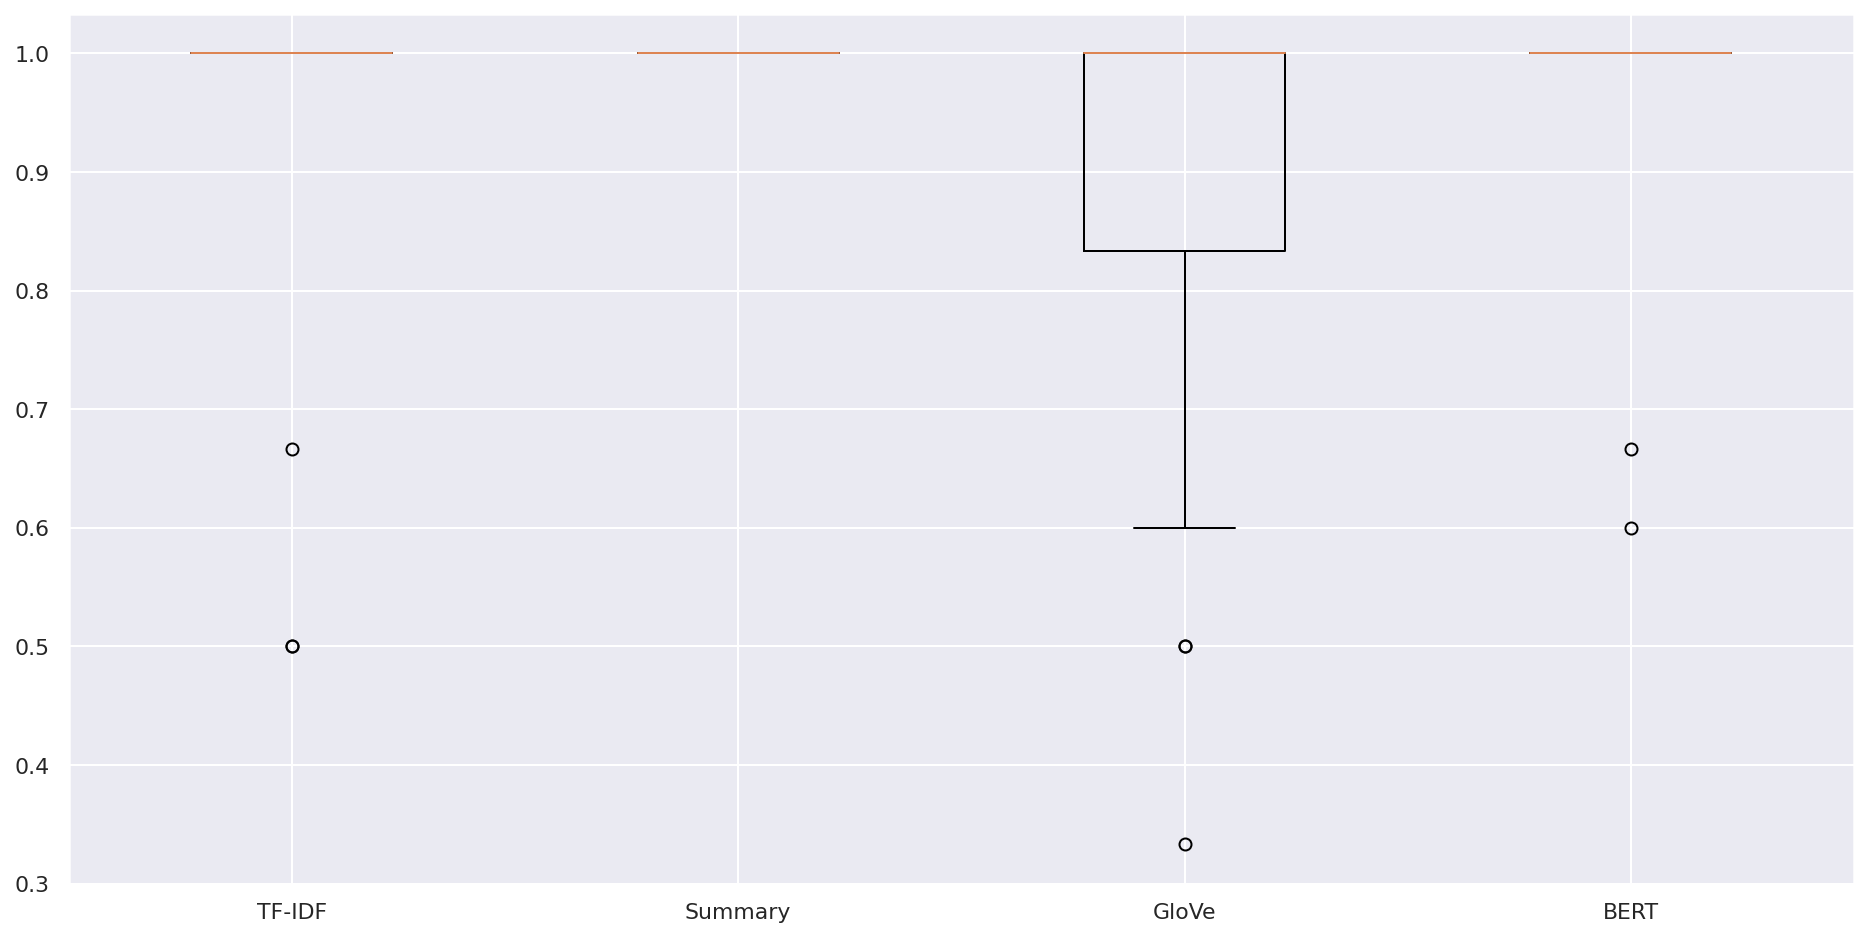

In [49]:
compare_boxplots([tfidf_max_recall, summary_max_recall, glove_max_recall, bert_max_recall], 
                 plot_labels, 
                 use_plotly)

**Metric 7**: `max(precision[i])` s.t `recall[i] > threshold` where `threshold = 0.9`

In [50]:
tfidf_max_precision = [entry['max_precision'] for entry in tfidf_metrics_list if entry['max_precision'] is not None]
summary_max_precision = [entry['max_precision'] for entry in summary_metrics_list if entry['max_precision'] is not None]
glove_max_precision = [entry['max_precision'] for entry in glove_metrics_list if entry['max_precision'] is not None]
bert_max_precision = [entry['max_precision'] for entry in bert_metrics_list if entry['max_precision'] is not None]

In [51]:
print(f'tfidf_max_precision size: {len(tfidf_max_precision)}')
print(f'summary_max_precision size: {len(summary_max_precision)}')
print(f'glove_max_precision size: {len(glove_max_precision)}')
print(f'bert_max_precision size: {len(bert_max_precision)}')

tfidf_max_precision size: 20
summary_max_precision size: 20
glove_max_precision size: 20
bert_max_precision size: 20


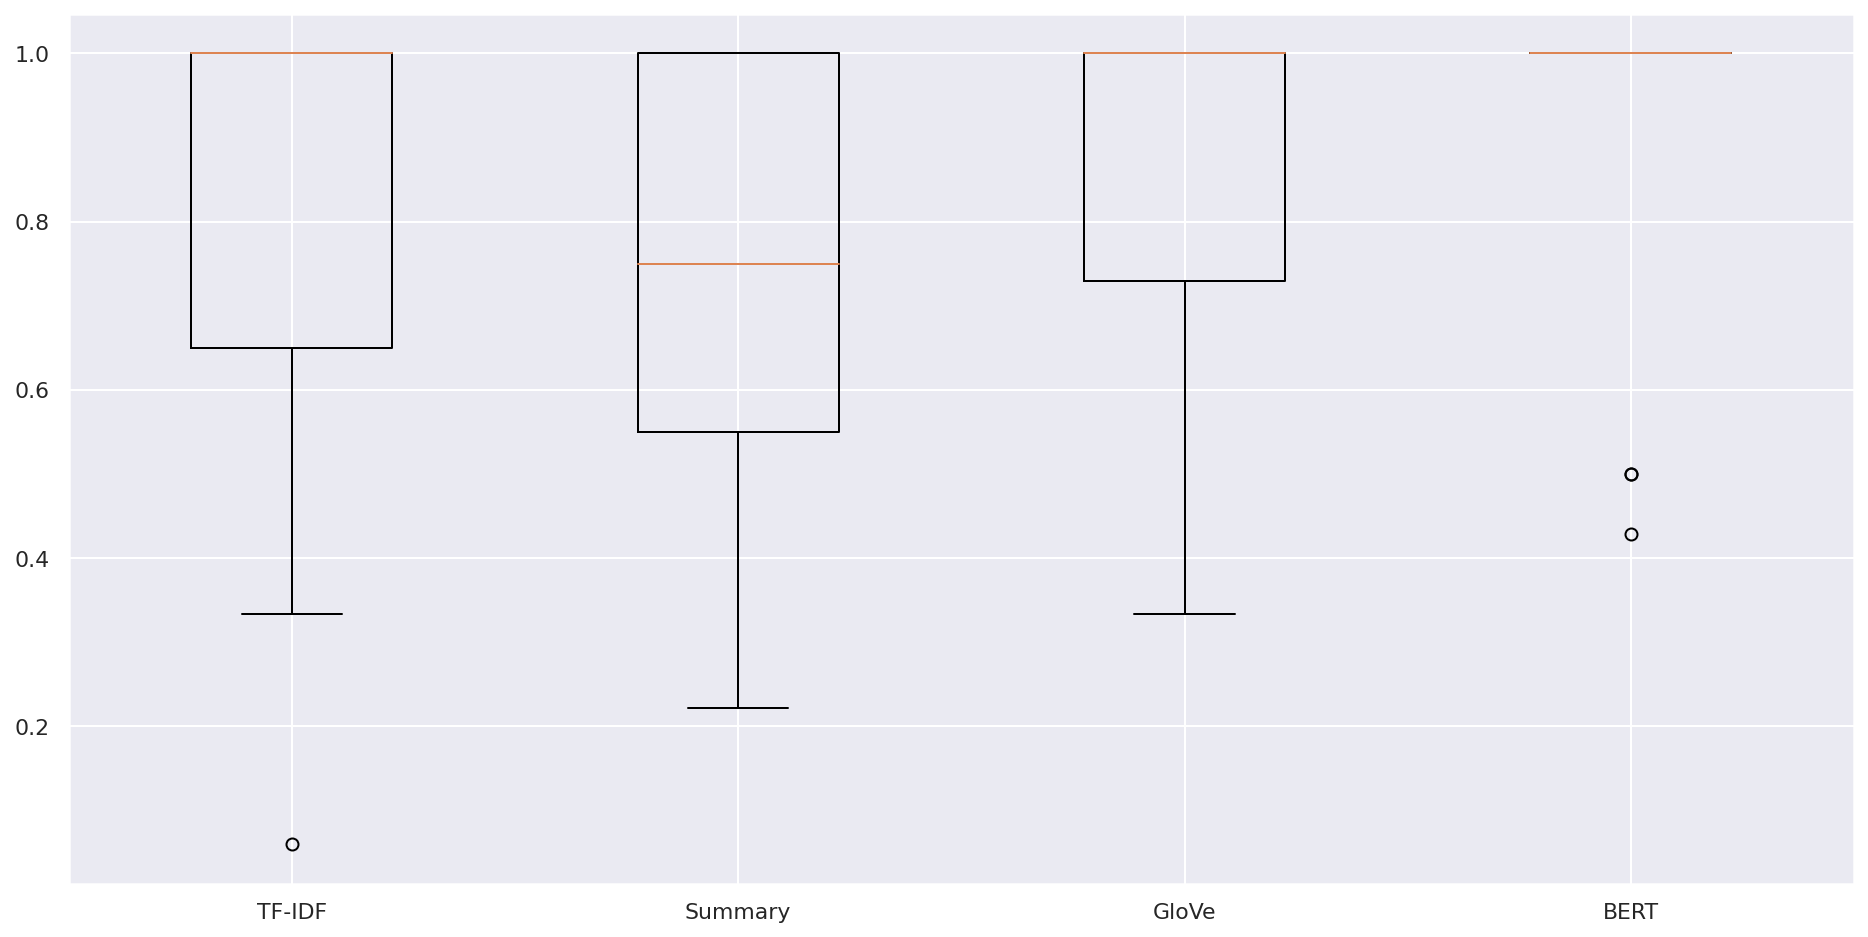

In [52]:
compare_boxplots([tfidf_max_precision, summary_max_precision, glove_max_precision, bert_max_precision], 
                 plot_labels,
                 use_plotly)

**Metric 8**: maximum recall at k

In [53]:
tfidf_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*tfidf_max_recall_at_k)]

summary_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*summary_max_recall_at_k)]

glove_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*glove_max_recall_at_k)]

bert_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*bert_max_recall_at_k)]

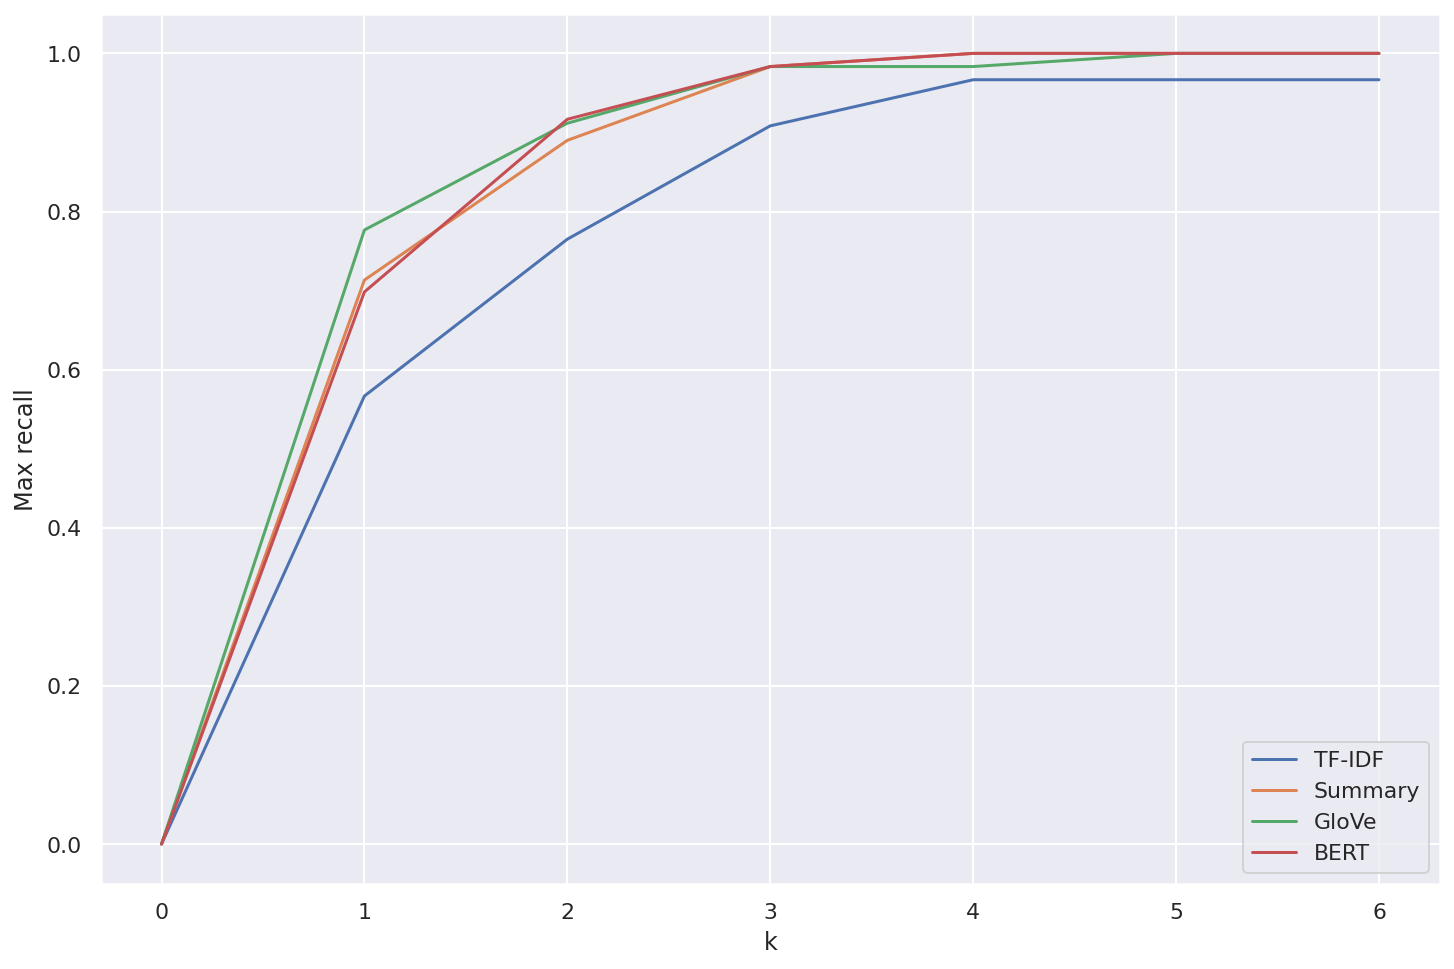

In [54]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_recall_at_k_avg, summary_max_recall_at_k_avg, glove_max_recall_at_k_avg, bert_max_recall_at_k_avg],
                  plot_labels,
                  'k', 
                  'Max recall', 
                  use_plotly)

**Metric 9**: maximum precision at k

In [55]:
tfidf_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*tfidf_max_precision_at_k)]

summary_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*summary_max_precision_at_k)]

glove_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*glove_max_precision_at_k)]

bert_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*bert_max_precision_at_k)]

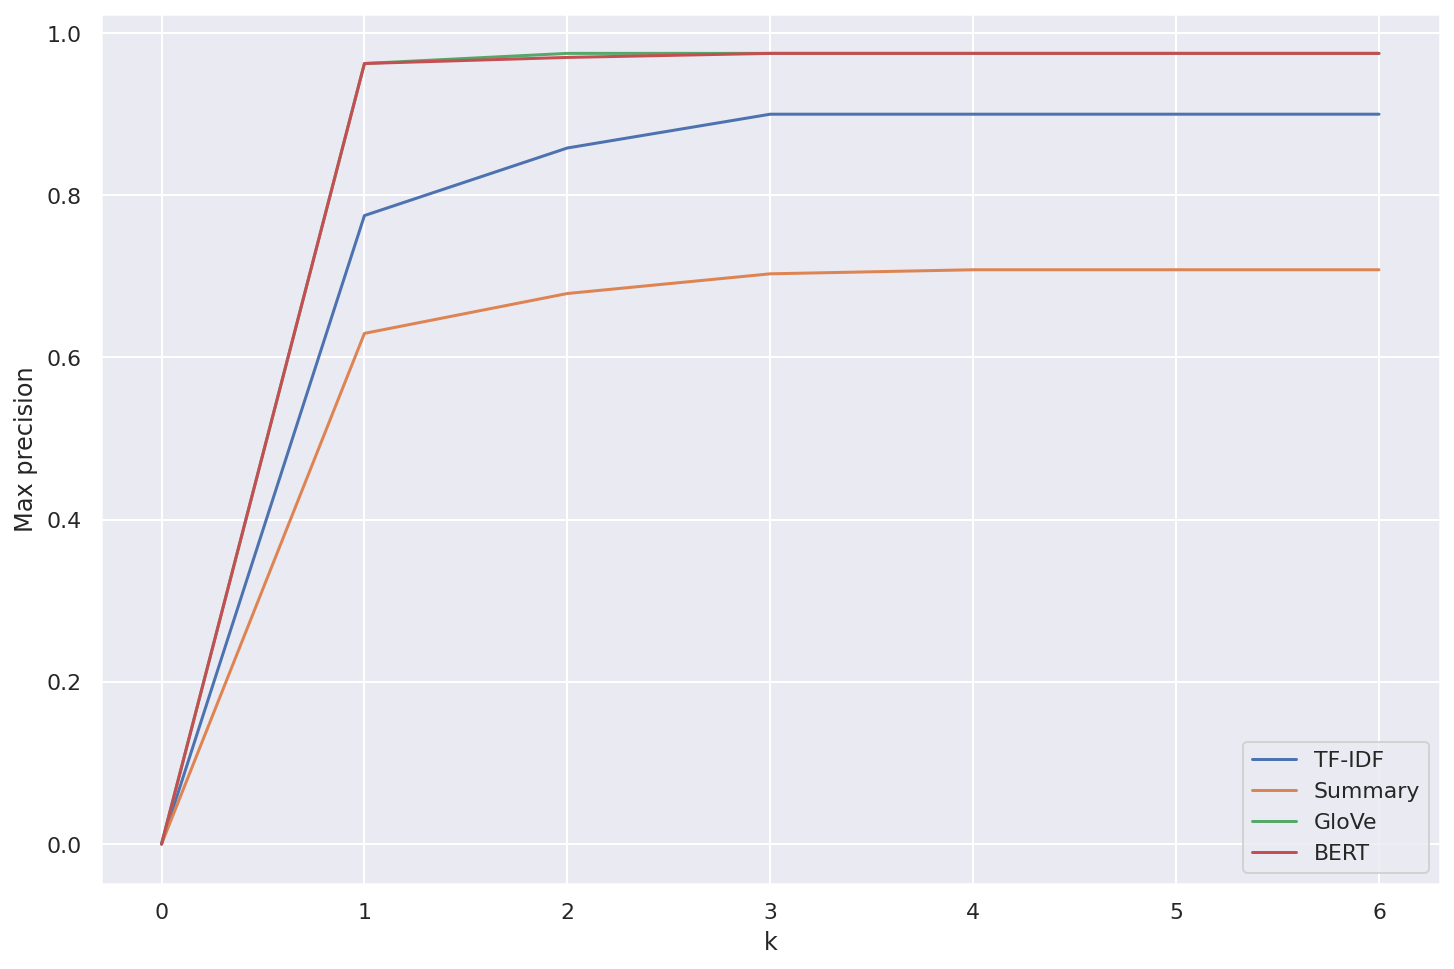

In [56]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_precision_at_k_avg, summary_max_precision_at_k_avg, glove_max_precision_at_k_avg, bert_max_precision_at_k_avg],
                  plot_labels,
                  'k', 
                  'Max precision', 
                  use_plotly)

---

## Write top N terms to file

In [57]:
filename = 'top_n_alaska.xlsx'
filepath = os.path.join(root_dir, data_dir, rank_dir, filename)

In [58]:
top_n = 100

In [59]:
from training import TrainingCorpus

In [60]:
with pd.ExcelWriter(filepath) as writer:
    for group_name, _ in grouped_tfidf_df:
        tfidf_terms = grouped_tfidf_df.get_group(group_name)['term'][:top_n].values
        summary_terms = grouped_summary_df.get_group(group_name)['term'][:top_n].values
        glove_terms = grouped_glove_df.get_group(group_name)['term'][:top_n].values
        bert_terms = grouped_bert_df.get_group(group_name)['term'][:top_n].values
        target = ' '.join(TrainingCorpus.tokenize(gt_dict[group_name])).lower()

        df = pd.DataFrame({'tfidf_term': pd.Series(tfidf_terms), 
                           'summary_term': pd.Series(summary_terms), 
                           'glove_term': pd.Series(glove_terms), 
                           'bert_term': pd.Series(bert_terms),
                           'target': target})
        df.to_excel(writer,
                    sheet_name=group_name, 
                    index=False)   

---